# Finite State Grammar Reconstruction
*Sophie Libkind*

This notebook explores the connection between the activations of an RNN trained to recognized a Finite State Grammar and the most compact machine producing the grammar.

In [1]:
import numpy as np
import math
import itertools
from IPython.display import clear_output
import operator
import random
import collections

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

In [135]:
entropy = lambda ps: -sum([p*np.log2(p) for p in ps])

## Finite-State Grammar

In [422]:
# A finite state grammar is represented as a dictionary with 
#      key - the state
#      value - a list of next states 

class FSG:

    def __init__(self, fsg, begin):
        '''
        fsg - a finite state grammar of the kind expressed above
        begin - the beginning state
        '''
        self.fsg = fsg
        self.curr = begin
        
    def generate(self, n, reset_curr):
        '''
        Generates a word in the FSG of length n
        Resets the current state of the FSG if the reset_curr flag is true
        '''
        curr = self.curr
        output = []
        while len(output) < n:
            nexts = self.fsg[curr].keys()
            ps = [self.fsg[curr][nx] for nx in nexts]
            i = np.random.choice(range(len(nexts)), p = ps)
            (nxt, out) = nexts[i]
            output.append(out)
            curr = nxt
        
        if reset_curr:
            self.curr = curr
        
        return output 
    
    def generate_with_probdists(self, n, reset_curr):
        '''
        Generates a word in the FSG of length n
        Also returns the probability distribution over the next characters at each step
        Resets the current state of the FSG if the reset_curr flag is true
        '''
        curr = self.curr
        output = []
        pdists = []
            
        while True:
            nexts = self.fsg[curr].keys()
            ps = [self.fsg[curr][nx] for nx in nexts]
            
            # accumulate probability distributions
            pdist = collections.defaultdict(int)
            for nx in nexts:
                pdist[nx[1]] += self.fsg[curr][nx]
            pdists.append(pdist)
            
            if len(output) > n:
                break
                
            # choose next letter
            i = np.random.choice(range(len(nexts)), p = ps)
            (nxt, out) = nexts[i]
            output.append(out)
            curr = nxt

        if reset_curr:
            self.curr = curr
        
        return output, pdists
    
    def is_grammatical(self,word):
        '''
        Decides if the word is grammatical with respect to the FSG
        '''
        currs = [self.curr]
        for letter in word:
            if len(currs) == 0:
                return False
            nexts = []
            for state in currs:
                nexts += [trans[0] for trans in self.fsg[state].keys() if trans[1] == letter]
            currs = nexts

        if len(currs) > 0:
            return True
        
        return False

## RNN

This simple RNN is based on Andrej Karpathy's Minimal character-level Vanilla RNN model at: https://gist.github.com/karpathy/d4dee566867f8291f086

In [469]:
class RNN:
    def __init__(self, data, hidden_size):
        self.training_chars = data        
        self.hidden_size = hidden_size
        # data I/O
        chars = list(set(data))
        data_size, self.vocab_size = len(data), len(chars)
        print 'data has %d characters, %d unique.' % (data_size, self.vocab_size)
        self.char_to_ix = { ch:i for i,ch in enumerate(chars) }
        self.ix_to_char = { i:ch for i,ch in enumerate(chars) }

        # hyperparameters
        self.hidden_size = 3 # size of hidden layer of neurons
        seq_length = 25 # number of steps to unroll the RNN for
        learning_rate = 1e-1
        
        # model parameters
        self.Wxh = np.random.randn(self.hidden_size, self.vocab_size)*0.01 # input to hidden
        self.Whh = np.random.randn(self.hidden_size, self.hidden_size)*0.01 # hidden to hidden
        self.Why = np.random.randn(self.vocab_size, self.hidden_size)*0.01 # hidden to output
        self.bh = np.zeros((self.hidden_size, 1)) # hidden bias
        self.by = np.zeros((self.vocab_size, 1)) # output bias


        n, p = 0, 0
        mWxh, mWhh, mWhy = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
        mbh, mby = np.zeros_like(self.bh), np.zeros_like(self.by) # memory variables for Adagrad
        smooth_loss = -np.log(1.0/self.vocab_size)*seq_length # loss at iteration 0

        hprev = np.zeros((self.hidden_size,1)) # reset RNN memory
        p = 0 # go from start of data
        
        while True:
            seq_length = min(seq_length, len(data) - p - 1)
                
            inputs = [self.char_to_ix[ch] for ch in data[p:p+seq_length]]
            targets = [self.char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

            # forward seq_length characters through the net and fetch gradient
            loss, dWxh, dWhh, dWhy, dbh, dby, hprev = self.lossFun(inputs, targets, hprev)
            smooth_loss = smooth_loss * 0.999 + loss * 0.001
            if n % 1000 == 0: 
                print 'iter %d, loss: %f' % (n, smooth_loss) # print progress

            # perform parameter update with Adagrad
            for param, dparam, mem in zip([self.Wxh, self.Whh, self.Why, self.bh, self.by], 
                                        [dWxh, dWhh, dWhy, dbh, dby], 
                                        [mWxh, mWhh, mWhy, mbh, mby]):
                mem += dparam * dparam
                param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

            p += seq_length # move data pointer
            n += 1 # iteration counter 
            if (p == len(data) - 1):
                break

        clear_output()
        print  'iter %d, loss: %f' % (n, smooth_loss)
        
    def lossFun(self, inputs, targets, hprev, reset_lasth = True):
        """
        inputs,targets are both list of integers.
        hprev is Hx1 array of initial hidden state
        returns the loss, gradients on model parameters, and last hidden state
        """
        xs, hs, ys, ps = {}, {}, {}, {}
        hs[-1] = np.copy(hprev)
        loss = 0
        # forward pass
        for t in xrange(len(inputs)):            
            xs[t] = np.zeros((self.vocab_size,1)) # encode in 1-of-k representation
            xs[t][inputs[t]] = 1
            hs[t] = np.tanh(np.dot(self.Wxh, xs[t]) + np.dot(self.Whh, hs[t-1]) + self.bh) # hidden state
            ys[t] = np.dot(self.Why, hs[t]) + self.by # unnormalized log probabilities for next chars
            ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
            loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
        
        if reset_lasth:
            self.last_h = hs[t]
            
        # backward pass: compute gradients going backwards
        dWxh, dWhh, dWhy = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
        dbh, dby = np.zeros_like(self.bh), np.zeros_like(self.by)
        dhnext = np.zeros_like(hs[0])
        for t in reversed(xrange(len(inputs))):
            dy = np.copy(ps[t])
            dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
            dWhy += np.dot(dy, hs[t].T)
            dby += dy
            dh = np.dot(self.Why.T, dy) + dhnext # backprop into h
            dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
            dbh += dhraw
            dWxh += np.dot(dhraw, xs[t].T)
            dWhh += np.dot(dhraw, hs[t-1].T)
            dhnext = np.dot(self.Whh.T, dhraw)
        for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
        return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

    def sample(self, n):
        """ 
        sample a sequence of integers from the model 
        h is memory state, seed_ix is seed letter for first time step
        """
        h = self.last_h
        seed_ix = self.char_to_ix[self.training_chars[-1]]
        x = np.zeros((self.vocab_size, 1))
        x[seed_ix] = 1
        ixes = []
        
        for t in xrange(n):
            h = np.tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, h) + self.bh)
            y = np.dot(self.Why, h) + self.by
            p = np.exp(y) / np.sum(np.exp(y))
            p = np.square(p) / np.sum(np.square(p)) # improves chances of grabbing a more likely char
            ix = np.random.choice(range(self.vocab_size), p=p.ravel())
            x = np.zeros((self.vocab_size, 1))
            x[ix] = 1
            ixes.append(ix)
        
        return [self.ix_to_char[ix] for ix in ixes]

    def get_layers(self, word):
        """ 
        Returns the probability distribution on the final layer after each step of the RNN 
        """
        word = [self.training_chars[-1]] + word
        inputs = [self.char_to_ix[ch] for ch in word]
        xs, hs, ys, ps = {}, {}, {}, {}
        pdists = []
        hiddens = []
        hs[-1] = np.copy(self.last_h)
        loss = 0
        # forward pass
        for t in xrange(len(inputs)):            
            xs[t] = np.zeros((self.vocab_size,1)) # encode in 1-of-k representation
            xs[t][inputs[t]] = 1
            hs[t] = np.tanh(np.dot(self.Wxh, xs[t]) + np.dot(self.Whh, hs[t-1]) + self.bh) # hidden state
            ys[t] = np.dot(self.Why, hs[t]) + self.by # unnormalized log probabilities for next chars
            ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
            
            hiddens.append(hs[t])
            
            pdist = {}
            for ch in self.char_to_ix:
                ix = self.char_to_ix[ch]
                pdist[ch] = ps[t][ix]
                
            pdists.append(pdist)
        
        return hiddens, pdists


## Example

Here we train an RNN on the finite-state gramer used by Reber (1976) and later by Sevan-Schreiber, Cleeremans, and McClelland (1991) to explore the architecture of Graded State Machines of which RNNs are an example.

Below is an image of the FSG taken from their paper. One minor change we make here is to run the FSG infinitely by returning to the beginning state after reaching the ending state. Each transition occurs with uniform probability.
<img src="images/reberFSG.png">

In [491]:
reber76 = {
    0: {(1, "B"): 1},
    1: {(2, "T"): 0.5, (3, "P"): 0.5},
    2: {(2, "S"): 0.5, (4, "X"): 0.5},
    3: {(3, "T"): 0.5, (5, "V"): 0.5},
    4: {(3, "X"): 0.5, (-1, "S"): 0.5},
    5: {(4, "P"): 0.5, (-1, "V"): 0.5},
    -1: {(0, "E"): 1},
}

fsg = FSG(reber76, 0)
training_data = fsg.generate(400000, reset_curr = True)
rnn = RNN(training_data, 3)

iter 16000, loss: 13.200232


### Does the RNN sample grammatical words?

We sample words from the RNN by using the square of the  probability distribution on the final layer to sample the next character in the word. We take the square of the probabilities to temper the flattening created by the softmax. When taking a sample the hidden layer is initialized to the last hidden layer during training and the input is initialized to the last character of the training data.

A word is  considered grammatical if it could be generated by the FSG starting from the state where the training data ended.

In [493]:
num = 1000
sample_size = 100
samples = [rnn.sample(sample_size) for _ in range(num)]
grammatical = [s for s in samples if fsg.is_grammatical(s)]
print "%d samples of length %d, with %d unique" %(num, sample_size, len(set([str(s) for s in samples])))
print "%.2f percent were grammatical" %(len(grammatical)/float(num)*100)

1000 samples of length 100, with 1000 unique
97.10 percent were grammatical


### Does the RNN sample from the true probability distribution?

We want to check that the RNN is not just sampling a proper subset of the words that can be generated by the grammar, but will sample each word in the grammar with the same proability as it occurs in the grammar.

Let $P$ be the probability distribution over the next characters in the FSG and let $Q$ be the probability distribution on the final layer of the RNN. We compute the Kullback-Leibler divergence between the distributions. 

$$D_{KL}(P || Q) = \sum_x P(x)\log\frac{Q(x)}{P(x)}$$

In [494]:
kl = lambda p, q: - sum([p[x]* np.log(q[x]/p[x]) for x in p if p[x] > 0])
steps = 1000
word, pdists = fsg.generate_with_probdists(steps-1, reset_curr = False)
hiddens, qdists = rnn.get_layers(word)
divs = []

for i in range(len(pdists)):
    p = pdists[i]
    q = qdists[i]
    div = kl(p,q)
    divs.append(div)

print "The average KL divergence over %d steps is %.4f" %(steps, np.average(divs))

The average KL divergence over 1000 steps is 0.0071


For comparison, consider the average KL divergence between $P$ and $(1-a)P + a U$, a mixture of $P$ and the uniform distribution.

In [495]:
flat = {ch: 1.0/rnn.vocab_size for ch in rnn.char_to_ix.keys()}
inc = .1
a = 0
print "a \t Average KL Divergence"
print "-"*40
while a <= 1:
    for i in range(len(pdists)):
        p = pdists[i]
        noisies = []
        q = {x: (1-a) * p[x] + a * flat[x] for x in flat.keys()}     
        noisies.append(kl(p, q))
    
    print "%.1f \t %.4f" %(a, np.average(noisies))
    a += inc

a 	 Average KL Divergence
----------------------------------------
0.0 	 0.0000
0.1 	 0.0896
0.2 	 0.1881
0.3 	 0.2973
0.4 	 0.4199
0.5 	 0.5596
0.6 	 0.7221
0.7 	 0.9163
0.8 	 1.1575
0.9 	 1.4759
1.0 	 1.9459


## Activation States

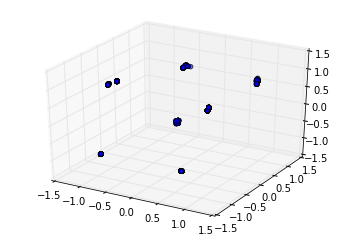

In [496]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
acts = np.array(hiddens).reshape(len(hiddens), rnn.hidden_size)
xs = acts.T[0]
ys = acts.T[1]
zs = acts.T[2]
ax.scatter(xs, ys, zs)

In [483]:
hiddens

[array([[ 0.99858991],
        [ 0.98100686],
        [-0.11050248]]), array([[-0.98525054],
        [ 0.9525945 ],
        [ 0.99977802]]), array([[-0.96816775],
        [ 0.03149665],
        [-0.98509771]]), array([[ 0.96603101],
        [-0.95454337],
        [-0.65513409]]), array([[ 0.99891919],
        [-0.92379546],
        [-0.63950878]]), array([[ 0.99941763],
        [ 0.30471987],
        [-0.99881309]]), array([[ 0.9971804 ],
        [ 0.93258291],
        [-0.06810323]]), array([[-0.98493266],
        [ 0.94636392],
        [ 0.99967358]]), array([[-0.9678271 ],
        [ 0.02520973],
        [-0.98553416]]), array([[ 0.96640937],
        [-0.9550942 ],
        [-0.66334845]]), array([[ 0.99946388],
        [ 0.2880198 ],
        [-0.99894961]]), array([[ 0.99725998],
        [ 0.93036051],
        [-0.1087564 ]]), array([[-0.98397432],
        [ 0.94759102],
        [ 0.99971266]]), array([[-0.96789055],
        [ 0.02628644],
        [-0.98542797]]), array([[ 0.96634335

In [497]:
import IPython
print IPython.sys_info()

{'commit_hash': u'5a894b9',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/Users/sophie/Library/Python/2.7/lib/python/site-packages/IPython',
 'ipython_version': '5.3.0',
 'os_name': 'posix',
 'platform': 'Darwin-16.6.0-x86_64-i386-64bit',
 'sys_executable': '/usr/bin/python',
 'sys_platform': 'darwin',
 'sys_version': '2.7.10 (default, Feb  7 2017, 00:08:15) \n[GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.34)]'}
